# Interactive Yoga Pose Classifier

This project is to use human body tracking and a recognition system to differentiate between different yoga poses and provide an accuracy rating for certain yoga poses submitted by the user. Our goal is for a user to be able to input a picture to our system and receive feedback on what yoga pose they are doing and how accurate their pose is. 

In [1]:
import keras 
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
import csv
import sklearn
from sklearn.utils import shuffle
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import os
from random import randint
from os import listdir
from os.path import isfile, join
from keras.models import load_model


Using TensorFlow backend.


# Intro To OpenPose Library

To extract information about the human body, we use an open source library called OpenPose. OpenPose does real-time multi-person keypoint detection and multi-threading. 

To better understand how OpenPose works, try running the code below. 


In [2]:
protoFile = "OpenPose-Multi-Person/pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "OpenPose-Multi-Person/pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 
'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 
'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip',
 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 
 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
          [47,48], [49,50], [53,54], [51,52], [55,56],
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]
def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


# Find valid connections between the different joints of a all persons present
def getValidPairs(output, frameWidth, frameHeight, detected_keypoints):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            invalid_pairs.append(k)
            valid_pairs.append([])
    return valid_pairs, invalid_pairs



# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

def perform_keypoint_analysis(filename, single=False):
    image1 = cv2.imread(filename)
    
    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]

    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                            (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)

        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)

    frameClone = image1.copy()
    for i in range(nPoints):
        for j in range(len(detected_keypoints[i])):
            cv2.circle(frameClone, detected_keypoints[i][j][0:2], 5, colors[i], -1, cv2.LINE_AA)

    valid_pairs, invalid_pairs = getValidPairs(output, frameWidth, frameHeight, detected_keypoints)

    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list)
    
    for i in range(17):
        for n in range(len(personwiseKeypoints)):
            index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
            if -1 in index:
                continue
            B = np.int32(keypoints_list[index.astype(int), 0])
            A = np.int32(keypoints_list[index.astype(int), 1])
            cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
    return detected_keypoints, frameClone, image1


Here's what OpenPose does:


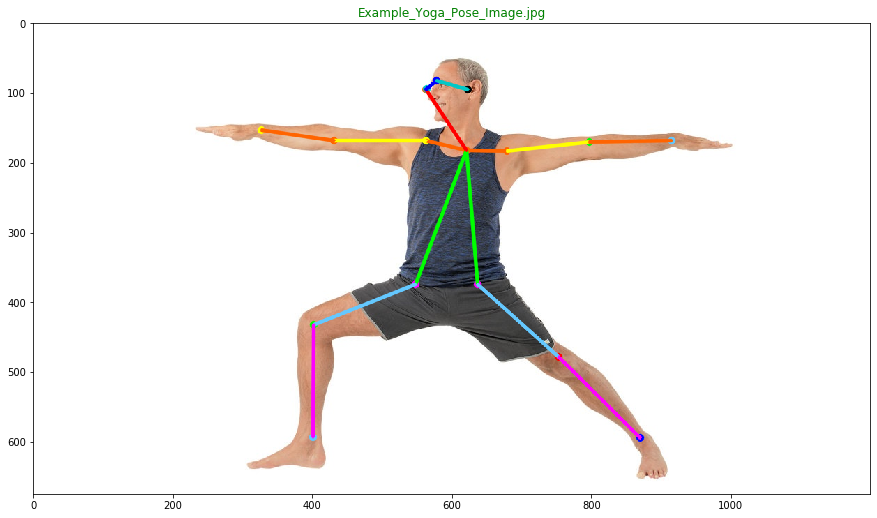

In [13]:
path_to_photo = "Example_Yoga_Pose_Image.jpg"
detected_keypoints, frameClone, image = perform_keypoint_analysis(path_to_photo, True)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])
plt.setp(plt.title(path_to_photo), color="g")
print("Here's what OpenPose does:")

# Now You Try!

Change the following block of code to use a file path to your own photo (.jpg or .png) of a yoga pose and see how well OpenPose can outline the pose.

In [4]:
path_to_photo = "Put your path here!"

if not isfile(path_to_photo):
    print("Make sure you change the first line to point to a .jpg or .png!")
else:
    detected_keypoints, frameClone, image = perform_keypoint_analysis(path_to_photo, True)
    plt.figure(figsize=[15,15])
    plt.imshow(frameClone[:,:,[2,1,0]])
    plt.setp(plt.title(path_to_photo), color="g")
    print("Here's what OpenPose does:")

Make sure you change the first line to point to a .jpg or .png!


# Training the Model

In order to build the recognition system to differentiate between different yoga poses we built a supervised machine learning model using Keras.


In this section we are randomizing the order of the data that we’ve extracted from our training set of photos. It is necessary to shuffle the photos around in order to ensure that our model is being trained without any biases. After shuffling the data we split the labels and the data points into two different arrays in order to feed this data to our model.


We train the model here


In [10]:

train = pd.read_csv("OpenPose-Multi-Person/scaled_data.csv")

train= train[['label', 'Nosex', 'Nosey', 'Neckx', 'Necky', 'R-Shox', 'R-Shoy',
       'R-Elbx', 'R-Elby', 'R-Wrx', 'R-Wry', 'L-Shox', 'L-Shoy', 'L-Elbx',
       'L-Elby', 'L-Wrx', 'L-Wry', 'R-Hipx', 'R-Hipy', 'R-Kneex', 'R-Kneey',
       'R-Ankx', 'R-Anky', 'L-Hipx', 'L-Hipy', 'L-Kneex', 'L-Kneey', 'L-Ankx',
       'L-Anky', 'R-Eyex', 'R-Eyey', 'L-Eyex', 'L-Eyey', 'R-Earx', 'R-Eary',
       'L-Earx', 'L-Eary']]

before = train.loc[339]
train = shuffle(train)
after = train.loc[339]
features = train.columns[1:]

X = train[features].values
Y = train.label.values



In [9]:
model = load_model("yoga_pals_model.h5")
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 36)                1332      
_________________________________________________________________
dense_26 (Dense)             (None, 30)                1110      
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 124       
Total params: 2,566
Trainable params: 2,566
Non-trainable params: 0
_________________________________________________________________


# Convert your photo to scaled data points

Now you get an idea of how OpenPose and Keras work, lets try and predict the pose from your image by running the next two cells

In [63]:
def predict_pose(result):
    result = result[0].tolist()
    ind  = result.index(max(result))
    labels = ['Mountain', 'Tree', 'Triangle', 'Warrior 2']
    return labels[ind]
def scale_keypoints(path):
    image1 = cv2.imread(path)
    

    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]

    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                            (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    print("Time Taken in forward pass = {}".format(time.time() - t))

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    minx = float('inf')
    maxx = float('-inf')
    miny = float('inf')
    maxy = float('-inf')
    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        for key in keypoints:
            if key[0] < minx:
                minx = key[0]
            if key[0] > maxx:
                maxx = key[0]
            if key[1] < miny:
                miny = key[1]
            if key[1] > maxy:
                maxy = key[1]
        #print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)
    diffx = maxx-minx
    diffy = maxy-miny
    box_size = max(diffx, diffy)
    if box_size == 0:
        print("Error, boxsize is 0. Diffx = {}, Diffy = {}".format(diffx, diffy))
        return []
    new_keypoints = []
    for keypoint in detected_keypoints:
        new_key = []
        for i in keypoint:
            newx = (i[0] - minx)/box_size
            newy = (i[1] - miny)/box_size
            new_key.append([newx, newy, i[2], i[3]])
        new_keypoints.append(new_key)
    result = []
    for i in new_keypoints:
        if i == []:
            result.append(-1)
            result.append(-1)
            continue
        result.append(i[0][0])
        result.append(i[0][1])
    return result



In [80]:
results = scale_keypoints(path_to_photo)

print("Scaled keypoint data: ")
for index in range(len(results)):
    print("{} : {}".format(features[index], results[index]))


Time Taken in forward pass = 2.5505220890045166
Scaled keypoint data: 
Nosex : 0.4013605442176871
Nosey : 0.022108843537414966
Neckx : 0.5
Necky : 0.17006802721088435
R-Shox : 0.4013605442176871
R-Shoy : 0.14625850340136054
R-Elbx : 0.17687074829931973
R-Elby : 0.14625850340136054
R-Wrx : 0.0
R-Wry : 0.12074829931972789
L-Shox : 0.5986394557823129
L-Shoy : 0.1717687074829932
L-Elbx : 0.7993197278911565
L-Elby : 0.14965986394557823
L-Wrx : 0.923469387755102
L-Wry : 0.8707482993197279
R-Hipx : 0.3758503401360544
R-Hipy : 0.4965986394557823
R-Kneex : 0.12755102040816327
R-Kneey : 0.5952380952380952
R-Ankx : 0.12585034013605442
R-Anky : 0.8690476190476191
L-Hipx : 0.5272108843537415
L-Hipy : 0.4965986394557823
L-Kneex : 0.7244897959183674
L-Kneey : 0.673469387755102
L-Ankx : 0.923469387755102
L-Anky : 0.8707482993197279
R-Eyex : 0.4030612244897959
R-Eyey : 0.02040816326530612
L-Eyex : 0.4268707482993197
L-Eyey : 0.0
R-Earx : -1
R-Eary : -1
L-Earx : 0.5034013605442177
L-Eary : 0.02210884353

# What do these numbers mean?
As you can see from the output, the keypoints are extracted from the photos and scaled from 0-1. If the key points have a value of -1, it means that that specific body part can’t be detected. 

# Guess the Pose
Run the last cell to see how well our model classified your pose!

In [84]:
print("Our model predicted that your pose is: " + predict_pose(model.predict(np.array([results]))))


Our model predicted that your pose is: Warrior 2
